In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [2]:
# Firstly we create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()

24/10/19 15:23:04 WARN Utils: Your hostname, Enchengs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.24.246.185 instead (on interface en0)
24/10/19 15:23:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/19 15:23:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('train.csv',header = 'True',inferSchema='True')
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [4]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



/var/folders/s3/jgy1vdy52sg293tj279nn0m40000gn/T/ipykernel_51484/2809843135.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df['Age'])


<Axes: title={'center': 'Age distribution among all Pasengers'}, xlabel='Age', ylabel='Density'>

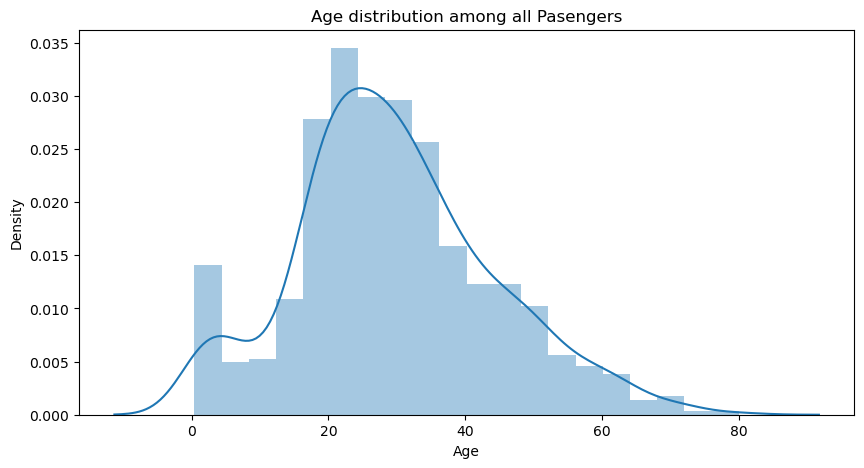

In [5]:
pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
plt.title('Age distribution among all Pasengers')
sns.distplot(pandas_df['Age'])

In [6]:
# find null values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [7]:
df = df.drop("Cabin") # remove Cabin since it has too much null values.

In [8]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/var/folders/s3/jgy1vdy52sg293tj279nn0m40000gn/T/ipykernel_51484/2347073437.py:1: SyntaxWarning: invalid escape sequence '\.'
  df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [9]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Checking the average age by Initials
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [10]:
# Assigning missing values in age feature based on average age of Initials
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))
# then done with ages

In [11]:
# Embarked columns has two missing values, let check it
df.groupBy("Embarked").count().show()


+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [12]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({"Embarked" : 'S'})

# Check again the missing value status
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [13]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch')) # Create new column: Family_size
df = df.withColumn('Alone',lit(0))  # Create new column: Alone and assign 0 default value to Alone column
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

# converting Sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [14]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [15]:
# Now we drop columns that not needed for modelling
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [19]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [20]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

In [21]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="Survived")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

24/10/19 15:45:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy:  0.8130434782608695
Precision:  0.8122400191250299


In [22]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/opt/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8787019533711404


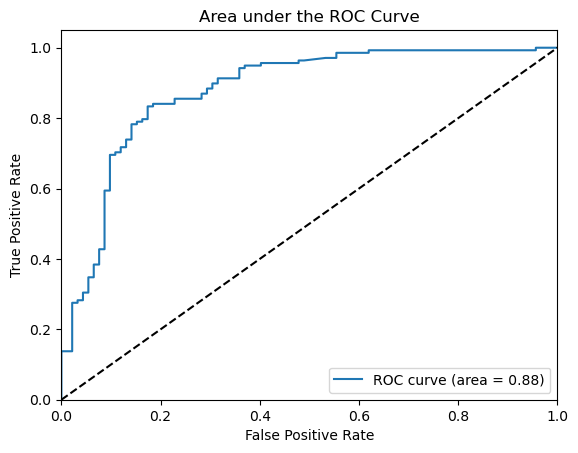

In [23]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

24/10/19 15:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1096.8 KiB
24/10/19 15:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1040.4 KiB
24/10/19 15:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1089.2 KiB
24/10/19 15:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1013.7 KiB
24/10/19 15:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.8 KiB
24/10/19 15:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1096.8 KiB
24/10/19 15:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1182.7 KiB
24/10/19 15:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1176.4 KiB
24/10/19 15:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1046.4 KiB
24/10/19 15:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1040.4 KiB
24/10/19 15:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1138.4 KiB
24/10/19 15:49:56 WAR

Accuracy:  0.8173913043478261
Precision:  0.8165458141067897


In [25]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/opt/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8811042848141145


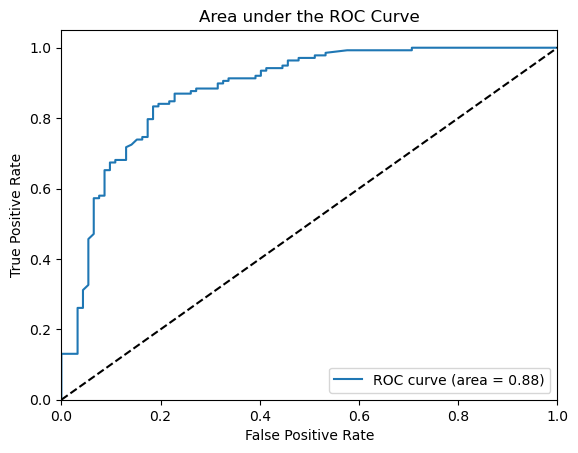

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()